In [1]:
# Library imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

import tools
from train import generate_graph, train

In [2]:
# Fix random seed for reproducibility
np.random.seed(628496)
random.seed(628496)

# Stop on errors
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Generate the synthetic data
edges_by_day, last_day, raw_accounts = tools.simulate_simple_data()

# Count the number of generated edges to validate that it has generated correctly
count_edges = sum(len(day) for day in edges_by_day.values())
print(f'There were {count_edges} edges generated.')

There were 240 edges generated.


In [4]:
# Remove 5% sales edges

# Count edges (0, 2)
debtor_settle_edge_days = []
for day in sorted(list(edges_by_day.keys())):
    edges = edges_by_day[day]
    for edge in edges:
        if edge[0] == 0 and edge[1] == 2:
            debtor_settle_edge_days.append((day, edge[0], edge[1], edge[2]))

count_removed_edges = int(len(debtor_settle_edge_days) * 0.05)

# Choose random edges
random_edges = random.sample(debtor_settle_edge_days, count_removed_edges)
random_days = set(edge[0] for edge in random_edges)

# Remove the edges from those days
for day, i, j, value in random_edges:
    edges_by_day[day].remove((i, j, value))

print(f'{count_removed_edges} edges were removed. {sum(len(edges) for edges in edges_by_day.values())} edges remaining.')

4 edges were removed. 236 edges remaining.


In [5]:
# Create a graph object with the generated accounts
graph = generate_graph(
    raw_accounts=raw_accounts,
    edges_by_day=edges_by_day,
    last_day=last_day,
    node_dimension=512,
    graph_kwords={
        'causal_learning_rate': 0.01,
        'spontaneous_learning_rate': 10**(-5),
        'weight_regularisation_rate': 10**(-5),
        'spontaneous_regularisation_rate': 10**(-7)
    }
)

In [6]:
# Train on the tainted data
probabilities = train(
    graph, edges_by_day, last_day, iterations=200,
    plot_log_likelihood=False, use_tqdm=True,
    spontaneous_learning_startpoint=75
    )

100%|██████████| 200/200 [27:16<00:00,  8.18s/it]


In [7]:
# Save the trained model and results
with open('saved_results//missing_edges_synthetic_spontaneous_results.pkl', 'wb') as f:
    pickle.dump((probabilities, graph), f)

In [8]:
# Find the probability that the number of a particular edge type on a particular
# day is lower than expected (suggesting edges have been removed/omitted)
all_probabilities = tools.return_probabilities_of_missing_edges(graph, edges_by_day, last_day)

100%|██████████| 365/365 [00:00<00:00, 382.59it/s]


In [9]:
print(f'There were {len(all_probabilities)} day-edge pairs (including those with count=0).')

There were 4380 day-edge pairs (including those with count=0).


In [10]:
# Sort the probabilities from most to least suspicious
all_probabilities.sort(key=lambda x: x[3], reverse=True)

In [11]:
# Find the locations of the added edges and the genuine edges
removed_rank = []
notremoved_rank = []
for i, edge in enumerate(all_probabilities):
    if edge[0] in random_days and edge[1] == 0 and edge[2] == 2:
        print(f'Item {i+1} of {len(all_probabilities)}:', edge)
        removed_rank.append(i)
    elif edge[1] == 0 and edge[2] == 2:
        notremoved_rank.append(i)

Item 24 of 4380: (41, 0, 2, 0.5152013197742199, 0, 0.7240215665372971, 5.9028367030380965e-06, 0.7240156637005941)
Item 85 of 4380: (145, 0, 2, 0.37138017680783075, 0, 0.4642286196526993, 1.0807930273049155e-06, 0.464227538859672)
Item 695 of 4380: (140, 0, 2, 0.04320017520656838, 1, 0.32733196494883554, 1.00951211338347e-06, 0.32733095543672214)
Item 975 of 4380: (68, 0, 2, 0.001292204298032007, 2, 0.20845258432624236, 2.7563998593020625e-06, 0.20844982792638306)


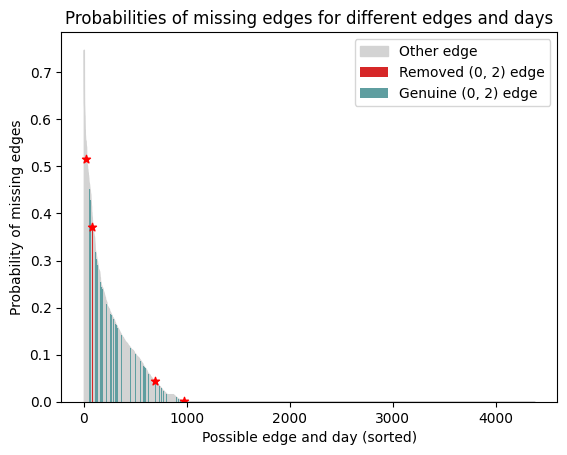

In [12]:
# Plot all the probabilities, highlighting which ones had edges removed and
# which ones related to the same edge type but were unamended
plt.fill_between(
    np.arange(len(all_probabilities)),
    np.zeros(len(all_probabilities)),
    np.array([edge[3] for edge in all_probabilities]),
    color='#d3d3d3',
    label='Other edge'
)
plt.bar(
    removed_rank,
    [all_probabilities[i][3] for i in removed_rank],
    width=1.0,
    color='#d62728',
    label='Removed (0, 2) edge'
)
plt.bar(
    notremoved_rank,
    [all_probabilities[i][3] for i in notremoved_rank],
    width=1.0,
    color='#5f9ea0',
    label='Genuine (0, 2) edge'
)
plt.scatter(
    removed_rank,
    [all_probabilities[i][3] for i in removed_rank],
    marker='*', c='red'
)

plt.legend(loc='upper right')

plt.xlabel('Possible edge and day (sorted)')
plt.ylabel('Probability of missing edges')
plt.title('Probabilities of missing edges for different edges and days')

plt.show()

In [13]:
print(f'Average removed rank: {np.mean([i+1 for i in removed_rank])}')
print(f'Genuine average rank: {np.mean([i+1 for i in notremoved_rank])}')

Average removed rank: 444.75
Genuine average rank: 857.786703601108
